# Depression and Anxiety classification with CSP spatial filter and different frequancy bands

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [1]:
import io
import os
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score


import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

Constatnts

In [2]:
random_state = 42

## Load questionnarie data

In [3]:
data = pd.read_csv('data/q_data.csv')

In [4]:
data['disorder'] = 0
for i in range(len(data)):
    if data['BDI'][i] != '#NULL!' and data['BDI'][i] >= 13:
        data['disorder'][i] = 1
    else:
        data['disorder'][i] = 0

/tmp/ipykernel_4802/1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
/tmp/ipykernel_4802/1494664159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 1


In [5]:
data

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder
0,507,99,NaN,1,19,0,0.00,0.00,0.00,23,...,753.41,722.02,828.73,728.22,721.10,905.28,785.73,0.12,0.00,0
1,508,99,NaN,1,18,4,0.00,0.67,0.17,47,...,932.63,772.36,986.75,771.2,896.43,1202.03,968.84,0.28,0.93,0
2,509,99,NaN,1,18,7,0.17,0.00,0.67,44,...,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0
3,510,99,NaN,1,19,1,0.00,0.00,0.17,27,...,1239.09,1231.04,1500.54,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0
4,511,99,NaN,2,22,1,0.00,0.00,0.17,23,...,1527.80,1908.43,1305.88,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,624,1,NaN,1,20,23,1.33,1.00,0.67,60,...,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81,1
115,625,2,subsyndromal current,1,19,16,0.67,1.00,0.83,60,...,1149.39,1130.02,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00,1
116,626,1,NaN,1,18,14,0.33,1.00,0.83,41,...,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38,1
117,627,2,NaN,2,19,30,1.00,1.33,2.17,47,...,2131.00,2065.05,2270.20,2167.89,1941.75,2261.39,2320.25,0.10,0.61,1


In [6]:
ids = data['id'][:].astype(int)

## Load EEG data

In [7]:
def read_epochs(group):
    epochs = []
    data_df = group.copy()
    for i in range(len(group)):
        fname = str(int(group.values[i, 0])) + "-epo.fif"
        print(fname)
        # this one doesn't exist|
        if fname == "599-epo.fif" or fname == "600-epo.fif":
            continue  
        epochs.append(mne.read_epochs('data/' + fname))
    data_df['epochs'] = epochs
    
    return data_df

In [8]:
%%capture
df_name = 'replication_data'
pickled_data_filename = 'data/' + df_name + '.pkl'

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    data_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    data_df = read_epochs (data)
    data_df.name = df_name
    # save loaded data into a pickle file
    data_df.to_pickle("data/" + data_df.name + ".pkl")
    print("Done. Pickle file created")

In [9]:
data_df.head()

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder,epochs,delta,theta
0,507,99,NaN,1,19,0,0.00,0.00,0.00,23,...,728.22,721.10,905.28,785.73,0.12,0.00,0,"<EpochsFIF | 107 events (all good), -0.5 - 1 ...","<EpochsFIF | 107 events (all good), -0.5 - 1 ...","<EpochsFIF | 107 events (all good), -0.5 - 1 ..."
1,508,99,NaN,1,18,4,0.00,0.67,0.17,47,...,771.2,896.43,1202.03,968.84,0.28,0.93,0,"<EpochsFIF | 354 events (all good), -0.5 - 1 ...","<EpochsFIF | 354 events (all good), -0.5 - 1 ...","<EpochsFIF | 354 events (all good), -0.5 - 1 ..."
2,509,99,NaN,1,18,7,0.17,0.00,0.67,44,...,794.16,736.67,830.53,741.74,0.07,0.05,0,"<EpochsFIF | 58 events (all good), -0.5 - 1 s...","<EpochsFIF | 58 events (all good), -0.5 - 1 s...","<EpochsFIF | 58 events (all good), -0.5 - 1 s..."
3,510,99,NaN,1,19,1,0.00,0.00,0.17,27,...,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0,"<EpochsFIF | 180 events (all good), -0.5 - 1 ...","<EpochsFIF | 180 events (all good), -0.5 - 1 ...","<EpochsFIF | 180 events (all good), -0.5 - 1 ..."
4,511,99,NaN,2,22,1,0.00,0.00,0.17,23,...,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0,"<EpochsFIF | 348 events (all good), -0.5 - 1 ...","<EpochsFIF | 348 events (all good), -0.5 - 1 ...","<EpochsFIF | 348 events (all good), -0.5 - 1 ..."


### Add frequency data

In [10]:
freq_ranges = [(0.0,3.5), (4.0,9.0)]

- add delta

In [11]:
%%capture

data_df['delta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[0][0], 
    freq_ranges[0][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 2.2,
))

In [12]:
data_df.head()

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder,epochs,delta
0,507,99,NaN,1,19,0,0.00,0.00,0.00,23,...,828.73,728.22,721.10,905.28,785.73,0.12,0.00,0,"<EpochsFIF | 107 events (all good), -0.5 - 1 ...","<EpochsFIF | 107 events (all good), -0.5 - 1 ..."
1,508,99,NaN,1,18,4,0.00,0.67,0.17,47,...,986.75,771.2,896.43,1202.03,968.84,0.28,0.93,0,"<EpochsFIF | 354 events (all good), -0.5 - 1 ...","<EpochsFIF | 354 events (all good), -0.5 - 1 ..."
2,509,99,NaN,1,18,7,0.17,0.00,0.67,44,...,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0,"<EpochsFIF | 58 events (all good), -0.5 - 1 s...","<EpochsFIF | 58 events (all good), -0.5 - 1 s..."
3,510,99,NaN,1,19,1,0.00,0.00,0.17,27,...,1500.54,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0,"<EpochsFIF | 180 events (all good), -0.5 - 1 ...","<EpochsFIF | 180 events (all good), -0.5 - 1 ..."
4,511,99,NaN,2,22,1,0.00,0.00,0.17,23,...,1305.88,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0,"<EpochsFIF | 348 events (all good), -0.5 - 1 ...","<EpochsFIF | 348 events (all good), -0.5 - 1 ..."


- add theta

In [13]:
%%capture

data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[1][0], 
    freq_ranges[1][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
))

In [14]:
data_df.head()

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder,epochs,delta,theta
0,507,99,NaN,1,19,0,0.00,0.00,0.00,23,...,728.22,721.10,905.28,785.73,0.12,0.00,0,"<EpochsFIF | 107 events (all good), -0.5 - 1 ...","<EpochsFIF | 107 events (all good), -0.5 - 1 ...","<EpochsFIF | 107 events (all good), -0.5 - 1 ..."
1,508,99,NaN,1,18,4,0.00,0.67,0.17,47,...,771.2,896.43,1202.03,968.84,0.28,0.93,0,"<EpochsFIF | 354 events (all good), -0.5 - 1 ...","<EpochsFIF | 354 events (all good), -0.5 - 1 ...","<EpochsFIF | 354 events (all good), -0.5 - 1 ..."
2,509,99,NaN,1,18,7,0.17,0.00,0.67,44,...,794.16,736.67,830.53,741.74,0.07,0.05,0,"<EpochsFIF | 58 events (all good), -0.5 - 1 s...","<EpochsFIF | 58 events (all good), -0.5 - 1 s...","<EpochsFIF | 58 events (all good), -0.5 - 1 s..."
3,510,99,NaN,1,19,1,0.00,0.00,0.17,27,...,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0,"<EpochsFIF | 180 events (all good), -0.5 - 1 ...","<EpochsFIF | 180 events (all good), -0.5 - 1 ...","<EpochsFIF | 180 events (all good), -0.5 - 1 ..."
4,511,99,NaN,2,22,1,0.00,0.00,0.17,23,...,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0,"<EpochsFIF | 348 events (all good), -0.5 - 1 ...","<EpochsFIF | 348 events (all good), -0.5 - 1 ...","<EpochsFIF | 348 events (all good), -0.5 - 1 ..."


In [18]:
data_df.to_pickle("data/" + df_name + ".pkl")

## Define groups

In [10]:
ctrl_dep = data_df[(data_df['BDI'] <= 13) & (data_df['TAI'] > 28)]
len(ctrl_dep)

45

In [11]:
dep = data_df[(data_df['BDI'] > 13) & (data_df['TAI'] > 28)]
len(dep)

45

In [12]:
anx = data_df[(data_df['BDI'] < 7) & (data_df['TAI'] > 31)]
len(anx)

29

In [13]:
ctrl_anx = data_df[(data_df['BDI'] < 7) & (data_df['TAI'] < 29)]
len(ctrl_anx)

29

### Visualization

- depression

In [14]:
dep_data_rewp = [epoch['good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in dep['epochs']]
dep_data_frn = [epoch['bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in dep['epochs']]
ctrl_dep_data_rewp = [epoch['good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_dep['epochs']]
ctrl_dep_data_frn = [epoch['bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_dep['epochs']]

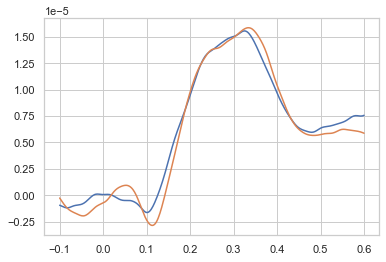

In [15]:
plt.plot(np.linspace(-0.1, 0.6, 350), np.nanmean(dep_data_rewp, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_frn, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.nanmean(ctrl_dep_data_rewp, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_frn, axis=0)[0])

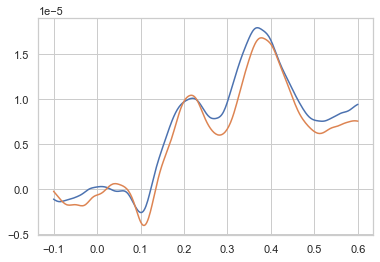

In [16]:
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.nanmean(dep_data_frn, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.nanmean(ctrl_dep_data_frn, axis=0)[0])

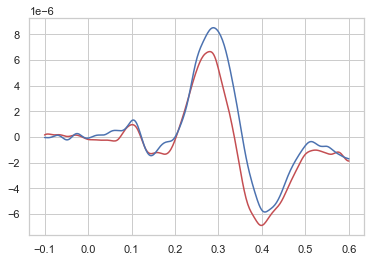

In [17]:
plt.plot(np.linspace(-0.1, 0.6, 350), (np.nanmean(dep_data_rewp, axis=0)[0] - np.nanmean(dep_data_frn, axis=0)[0]), color='r')
plt.plot(np.linspace(-0.1, 0.6, 350), (np.nanmean(ctrl_dep_data_rewp, axis=0)[0] - np.nanmean(ctrl_dep_data_frn, axis=0)[0]), color='b')

- anxiety

In [18]:
anx_data_rewp = [epoch['good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in anx['epochs']]
anx_data_frn = [epoch['bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in anx['epochs']]
ctrl_anx_data_rewp = [epoch['good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_anx['epochs']]
ctrl_anx_data_frn = [epoch['bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_anx['epochs']]

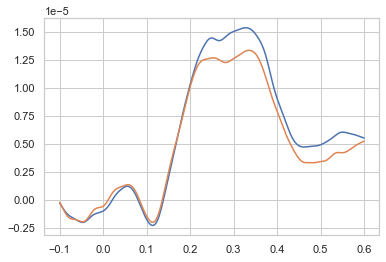

In [19]:
plt.plot(np.linspace(-0.1, 0.6, 350), np.mean(anx_data_rewp, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(anx_data_frn, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.mean(ctrl_anx_data_rewp, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(ctrl_anx_data_frn, axis=0)[0])

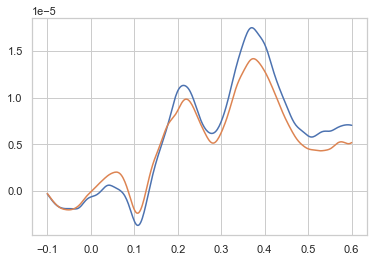

In [20]:
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(anx_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.mean(anx_data_frn, axis=0)[0])
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(ctrl_anx_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 350), np.mean(ctrl_anx_data_frn, axis=0)[0])

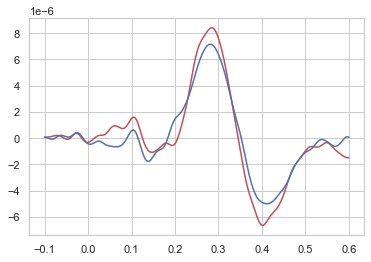

In [21]:
plt.plot(np.linspace(-0.1, 0.6, 350), (np.nanmean(anx_data_rewp, axis=0)[0] - np.nanmean(anx_data_frn, axis=0)[0]), color='r')
plt.plot(np.linspace(-0.1, 0.6, 350), (np.nanmean(ctrl_anx_data_rewp, axis=0)[0] - np.nanmean(ctrl_anx_data_frn, axis=0)[0]), color='b')

## Classification

In [63]:
# Calculating p-value with permutation test from sci-kit learn

def calculate_p_permutations(estimator, X, y, cv=3, n_permutations=1000, n_jobs=1):

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator, X, y, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs
    )

    # summarize
    print(f"     The permutation P-value is = {pvalue_:.4f}")
    print(f"     The permutation score is = {score_:.4f}\n")

    return score_, pvalue_

In [64]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    classifier_params,
    pipeline_name,
    cv=StratifiedKFold(n_splits=5),
    predict_test = True,
    predict_train = True,
    ):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        classifier_params,
        cv=cv,
        scoring={"roc_auc", "balanced_accuracy", "precision", "recall"},
        refit="balanced_accuracy",
        return_train_score=True,
        verbose=10,
        n_jobs=1,
        
    )

    # fit model
    grid_search_model.fit(X_train, y_train)

    # predict test data
    # y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    # test_score = roc_auc_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X_train) if predict_train is True else None
    train_score = roc_auc_score(y_train, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_
    
    # report
    # classification_report_ = classification_report(y_test, y_test_pred, labels=[0,1])

    # extract splits scores
    # ta linijka wyciąga z cv_results, czyli z DF z wynikami wszystkich testowanych 
    # w GS parametrów scory na kolejnych splitach cross-validacji
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_roc_auc").reset_index(drop=True) 

    # wyciąganie scorów na teście dla matryk zdefiniowanych w scoring
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)
    
    # calculate p-value
    scores_, pvalue_ = calculate_p_permutations(
            grid_search_model.best_estimator_, X_train, y_train, cv=cv
        )


    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            # "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            "pvalue":[pvalue_],    
            }),
         cv_splits_scores_df,
         metrics_results_df,
        ],
    axis=1
    ) 

    return this_result

Define estimators

In [65]:
lg = ('lg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))
lg_params = dict()

svc = ('svc' , SVC())
svc_params = dict(
    svc__kernel=["linear", "rbf"],
    svc__C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

lda = ("lda", LinearDiscriminantAnalysis())
lda_params = dict(
    lda__solver = ["lsqr", "eigen"],
    lda__shrinkage = ["auto"],
)


estimators = [
    # (lg, lg_params),
    (svc, svc_params),
    # (lda, lda_params)
]

Define CSP

In [66]:
csp = ('csp', CSP(log=None, norm_trace=False))
csp_params = dict(
    csp__n_components = [1,2,3,4],
    csp__reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
)

### Depression vs Control

#### RewP

In [67]:
tmin = 0.25
tmax = 0.35

In [68]:
rewp_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep[freq].to_numpy()]
    ctrl_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    rewp_depression_datasets.append(X)

In [414]:
# rewp_depression_datasets = []
# frequencies = ['delta', 'theta']

# for freq in frequencies:
#     dep_data = [mne.filter.resample(epoch['good'].average().get_data(tmin=tmin, tmax=tmax,), down=2.0) for epoch in dep[freq].to_numpy()]
#     ctrl_data = [mne.filter.resample(epoch['good'].average().get_data(tmin=tmin, tmax=tmax,), down=2.0) for epoch in ctrl_dep[freq].to_numpy()]

#     X = np.array(dep_data + ctrl_data)
#     rewp_depression_datasets.append(X)

In [69]:
np.save('data/frequency_data/rewp_depression_dataset_25-35.npy', rewp_depression_datasets)    # .npy extension is added if not given

In [342]:
# rewp_depression_datasets = np.load('data/frequency_data/rewp_depression_dataset_22-35_down.npy')

In [29]:
%%capture

vec = Vectorizer()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

results_dep_rewp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(rewp_depression_datasets):

    X = dataset
    class_len = int(np.array(rewp_depression_datasets).shape[1]/2)
    y = np.array(class_len * [1] +  class_len * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = "RewP_Depression_band_" + str(index) + "_" + estimator[0]

        clf = Pipeline([csp] + [('vec', vec)] + [estimator])
        classifier_params = {**global_params, **params}

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_dep_rewp_df = pd.concat([results_dep_rewp_df, grid_result])

In [355]:
results_dep_rewp_df # 23 - 35  down 2

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Depression_band_0_svc,0.722222,0.622222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 1, 'svc__...",0.039960,0.555556,0.706667,0.573333,0.611852,0.666667,0.622222,0.610648
0,svc,RewP_Depression_band_1_svc,0.877778,0.666667,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.004995,0.773333,0.573333,0.688889,0.678519,0.644444,0.666667,0.688375


In [416]:
results_dep_rewp_df # 25 - 35  down 2

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Depression_band_0_svc,0.677778,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.01, 'sv...",0.028971,0.613333,0.533333,0.586667,0.577778,0.644444,0.600000,0.600198
0,svc,RewP_Depression_band_1_svc,0.811111,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.005994,0.742222,0.591111,0.786667,0.706667,0.666667,0.644444,0.643732


In [30]:
results_dep_rewp_df # 25 - 35 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_balanced_accuracy
0,svc,RewP_Depression_band_0_svc,0.666667,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.01, 'sv...",0.034965,0.608889,0.591111,0.551111,0.583704,0.644444,0.600198,0.600000
0,svc,RewP_Depression_band_1_svc,0.811111,0.655556,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.004995,0.742222,0.586667,0.808889,0.712593,0.666667,0.662048,0.655556


In [356]:
results_dep_rewp_df.to_pickle("data/depression_rewp_freq_results_12_04_down.pkl")

#### FRN

In [70]:
tmin = 0.26
tmax = 0.38

In [71]:
frn_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep[freq].to_numpy()]
    ctrl_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    frn_depression_datasets.append(X)

In [358]:
# frn_depression_datasets = []
# frequencies = ['delta', 'theta']

# for freq in frequencies:
#     dep_data = [mne.filter.resample(epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,), down=2.0) for epoch in dep[freq].to_numpy()]
#     ctrl_data = [mne.filter.resample(epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,), down=2.0) for epoch in ctrl_dep[freq].to_numpy()]

#     X = np.array(dep_data + ctrl_data)
#     frn_depression_datasets.append(X)

In [72]:
np.save('data/frequency_data/frn_depression_datasets_26-38.npy', frn_depression_datasets)    # .npy extension is added if not given

In [135]:
frn_depression_datasets = np.load('data/frequency_data/frn_depression_datasets_25-38.npy')

In [33]:
%%capture

vec = Vectorizer()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

results_dep_frn_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(frn_depression_datasets):

    X = dataset
    y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = "FRN_Depression_band_" + str(index) + "_" + estimator[0]

        clf = Pipeline([csp] + [('vec', vec)] + [estimator])
        classifier_params = {**global_params, **params}

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_dep_frn_df = pd.concat([results_dep_frn_df, grid_result])

In [360]:
results_dep_frn_df # 26 - 38 down 2.0

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Depression_band_0_svc,0.922222,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.01, 'sv...",0.040959,0.515556,0.626667,0.697778,0.613333,0.488889,0.600000,0.633333
0,svc,FRN_Depression_band_1_svc,0.622222,0.622222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.1, 'svc...",0.006993,0.528889,0.693333,0.608889,0.610370,0.733333,0.622222,0.596925


In [34]:
results_dep_frn_df # 26 - 38

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_balanced_accuracy
0,svc,FRN_Depression_band_0_svc,0.922222,0.611111,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.01, 'sv...",0.017982,0.515556,0.622222,0.693333,0.61037,0.488889,0.655363,0.611111
0,svc,FRN_Depression_band_1_svc,0.622222,0.633333,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.1, 'svc...",0.002997,0.533333,0.688889,0.608889,0.61037,0.733333,0.607026,0.633333


In [361]:
results_dep_frn_df.to_pickle("data/depression_frn_results_freq_12_04_down.pkl")

### Anxiety vs Control

#### RewP

In [83]:
tmin = 0.25
tmax = 0.35

In [84]:
rewp_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    rewp_anxiety_datasets.append(X)

In [85]:
np.save('data/frequency_data/rewp_anxiety_datasets_25-35.npy', rewp_anxiety_datasets)    # .npy extension is added if not given

In [364]:
%%capture

vec = Vectorizer()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

results_anx_rewp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(rewp_anxiety_datasets):

    X = dataset
    y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = "RewP_Anxiety_band_" + str(index) + "_" + estimator[0]

        clf = Pipeline([csp] + [('vec', vec)] + [estimator])
        classifier_params = {**global_params, **params}

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_anx_rewp_df = pd.concat([results_anx_rewp_df, grid_result])

In [370]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Anxiety_band_0_svc,0.810345,0.638889,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.032967,0.63,0.700000,0.488889,0.606296,0.792593,0.638889,0.606838
0,svc,RewP_Anxiety_band_1_svc,0.827586,0.659259,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.01, 'sv...",0.006993,0.56,0.444444,0.922222,0.642222,0.696296,0.659259,0.647619


In [365]:
results_anx_rewp_df.to_pickle("data/anxiety_rewp_freq_results_12_04.pkl")

#### FRN

In [80]:
tmin = 0.26
tmax = 0.38

In [81]:
frn_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    frn_anxiety_datasets.append(X)

In [82]:
np.save('data/frequency_data/frn_anxiety_datasets_26-38.npy', frn_anxiety_datasets)    # .npy extension is added if not given

In [368]:
%%capture

vec = Vectorizer()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

results_anx_frn_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(frn_anxiety_datasets):

    X = dataset
    y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = "FRN_Anxiety_band_" + str(index) + "_" + estimator[0]

        clf = Pipeline([csp] + [('vec', vec)] + [estimator])
        classifier_params = {**global_params, **params}

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_anx_frn_df = pd.concat([results_anx_frn_df, grid_result])

In [371]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Anxiety_band_0_svc,0.810345,0.672222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.1, 'svc...",0.008991,0.66,0.711111,0.555556,0.642222,0.722222,0.672222,0.654545
0,svc,FRN_Anxiety_band_1_svc,0.775862,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 1, 'svc__...",0.051948,0.76,0.744444,0.655556,0.720000,0.625926,0.644444,0.713889


In [369]:
results_anx_frn_df.to_pickle("data/anxiety_frn_freq_results_12_04.pkl")

## Test statistical differences between models

In [35]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X_1,
    X_2,
    y,
    scoring='accuracy',
    random_state=0  
):
    """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    cv_scores_1 = cross_val_score(estimator1, X_1, y, cv=cv, scoring=scoring)
    cv_scores_2 = cross_val_score(estimator2, X_2, y, cv=cv, scoring=scoring)

    differences = cv_scores_1 - cv_scores_2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    n_train = len(list(cv.split(X_1, y))[0][0])
    n_test = len(list(cv.split(X_1, y))[0][1])

    t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

    return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [53]:
# results_dep_rewp_df = pd.read_pickle("data/depression_rewp_results_3_02_03_24-00.pkl")
# results_dep_frn_df = pd.read_pickle("data/depression_frn_results_3_02_03_24-00.pkl")
# results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_results.pkl")
# results_anx_frn_df = pd.read_pickle("data/anxiety_frn_results_25_37.pkl")

### Depression RewP vs FRN

In [36]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

#### Plot differences between all Depression Models
To see which RewP and FRN models are the best

In [37]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

cv_scores_rewp_delta = cross_val_score(results_dep_rewp_df.iloc[0].best_model, rewp_depression_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_rewp_theta = cross_val_score(results_dep_rewp_df.iloc[1].best_model, rewp_depression_datasets[1], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_delta = cross_val_score(results_dep_frn_df.iloc[0].best_model, frn_depression_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_theta = cross_val_score(results_dep_frn_df.iloc[1].best_model, frn_depression_datasets[1], y, cv=cv,scoring='balanced_accuracy')
    
cv_results_df["RewP_delta"] = cv_scores_rewp_delta
cv_results_df["RewP_theta"] = cv_scores_rewp_theta
cv_results_df["FRN_delta"] = cv_scores_frn_delta
cv_results_df["FRN_theta"] = cv_scores_frn_theta

In [298]:
cv_results_df.head()

,RewP_delta,RewP_theta,FRN_delta,FRN_theta
0,0.325,0.675,0.575,0.475
1,0.450,0.575,0.600,0.700
2,0.625,0.750,0.350,0.425
3,0.875,0.575,0.575,0.675
4,0.400,0.225,0.475,0.625


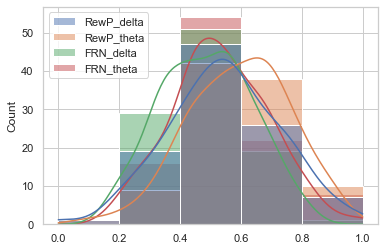

In [427]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

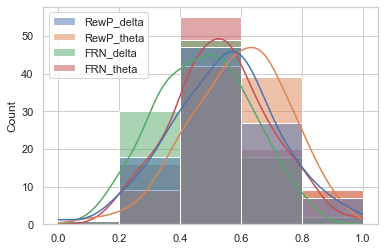

In [38]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [419]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Depression_band_0_svc,0.677778,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.01, 'sv...",0.028971,0.613333,0.533333,0.586667,0.577778,0.644444,0.600000,0.600198
0,svc,RewP_Depression_band_1_svc,0.811111,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.005994,0.742222,0.591111,0.786667,0.706667,0.666667,0.644444,0.643732


In [420]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Depression_band_0_svc,0.922222,0.600000,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.01, 'sv...",0.040959,0.515556,0.626667,0.697778,0.613333,0.488889,0.600000,0.633333
0,svc,FRN_Depression_band_1_svc,0.622222,0.622222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 0.1, 'svc...",0.006993,0.528889,0.693333,0.608889,0.610370,0.733333,0.622222,0.596925


In [41]:
index = 1

In [42]:
dep_rewp_model = results_dep_rewp_df.iloc[index].best_model
dep_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fa58b7aae50>),
                ('svc', SVC(C=1))])

In [43]:
dep_frn_model = results_dep_frn_df.iloc[index].best_model
dep_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 1,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fa58b3e0ee0>),
                ('svc', SVC(C=1, kernel='linear'))])

In [44]:
X_rewp = rewp_depression_datasets[index]
X_frn = frn_depression_datasets[index]

- Balanced Accuracy

In [48]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [49]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.806
p value: 0.211


- Roc AUC

In [328]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [329]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.672
p value: 0.251


- precision

In [272]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [273]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.294
p value: 0.385


- recall

In [274]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [275]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.202
p value: 0.420


- F1

In [276]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [277]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.302
p value: 0.382


Visualize difference between FRN and RewP models

In [45]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [46]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

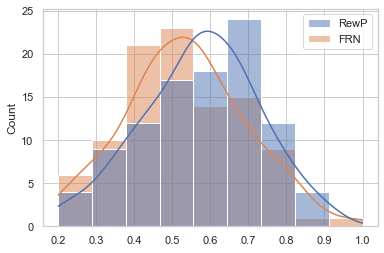

In [324]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

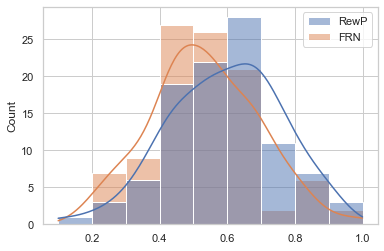

In [430]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

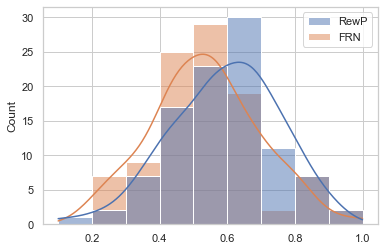

In [47]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [325]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [326]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

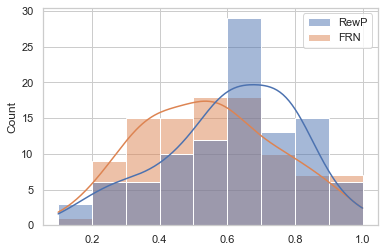

In [327]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

### Anxiety RewP vs FRN

In [373]:
y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [374]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

cv_scores_rewp_delta = cross_val_score(results_anx_rewp_df.iloc[0].best_model, rewp_anxiety_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_rewp_theta = cross_val_score(results_anx_rewp_df.iloc[1].best_model, rewp_anxiety_datasets[1], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_delta = cross_val_score(results_anx_frn_df.iloc[0].best_model, frn_anxiety_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_theta = cross_val_score(results_anx_frn_df.iloc[1].best_model, frn_anxiety_datasets[1], y, cv=cv,scoring='balanced_accuracy')
    
cv_results_df["RewP_delta"] = cv_scores_rewp_delta
cv_results_df["RewP_theta"] = cv_scores_rewp_theta
cv_results_df["FRN_delta"] = cv_scores_frn_delta
cv_results_df["FRN_theta"] = cv_scores_frn_theta

In [375]:
cv_results_df.head()

,RewP_delta,RewP_theta,FRN_delta,FRN_theta
0,0.666667,0.500000,0.500000,0.666667
1,0.500000,0.500000,0.666667,0.500000
2,0.500000,0.666667,0.333333,0.833333
3,0.666667,0.333333,0.666667,0.500000
4,0.833333,0.500000,0.666667,0.666667


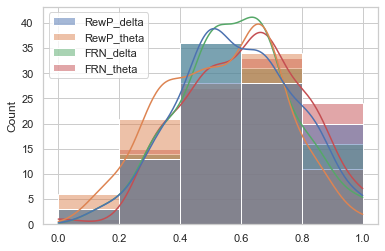

In [376]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [377]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Anxiety_band_0_svc,0.810345,0.638889,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.032967,0.63,0.700000,0.488889,0.606296,0.792593,0.638889,0.606838
0,svc,RewP_Anxiety_band_1_svc,0.827586,0.659259,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.01, 'sv...",0.006993,0.56,0.444444,0.922222,0.642222,0.696296,0.659259,0.647619


In [378]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Anxiety_band_0_svc,0.810345,0.672222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.1, 'svc...",0.008991,0.66,0.711111,0.555556,0.642222,0.722222,0.672222,0.654545
0,svc,FRN_Anxiety_band_1_svc,0.775862,0.644444,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 1, 'svc__...",0.051948,0.76,0.744444,0.655556,0.720000,0.625926,0.644444,0.713889


In [403]:
index = 0

In [404]:
anx_rewp_model = results_anx_rewp_df.iloc[index].best_model
anx_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fefda3e52b0>),
                ('svc', SVC(C=10, kernel='linear'))])

In [405]:
anx_frn_model = results_anx_frn_df.iloc[index].best_model
anx_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fefd9e5b8e0>),
                ('svc', SVC(C=1))])

In [406]:
X_rewp = rewp_anxiety_datasets[index]
X_frn = frn_anxiety_datasets[index]

- Balanced Accuracy

In [407]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [408]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.070
p value: 0.472


- Roc AUC

In [387]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [388]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.021
p value: 0.155


- precision

In [389]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [390]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.553
p value: 0.291


- recall

In [391]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [392]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.342
p value: 0.367


- F1

In [393]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [394]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.528
p value: 0.299


Visualize difference between FRN and RewP models

In [409]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [410]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

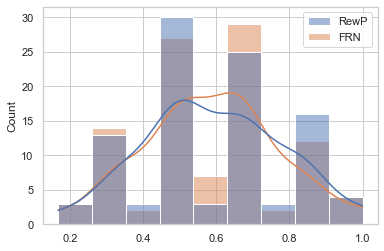

In [411]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [398]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [399]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

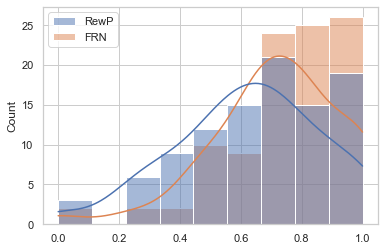

In [400]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

---

In [579]:
tmin = 0.25
tmax = 0.35

anx_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_rewp_data = [epoch['good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [580]:
X_rewp = np.array(anx_rewp_data + ctrl_rewp_data)

In [581]:
tmin = 0.25
tmax = 0.37

anx_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx_epochs]
ctrl_frn_data = [epoch['bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx_epochs]

In [582]:
X_frn = np.array(anx_frn_data + ctrl_frn_data)

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [160]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

cv_scores_rewp_delta = cross_val_score(results_anx_rewp_df.iloc[0].best_model, rewp_anxiety_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_rewp_theta = cross_val_score(results_anx_rewp_df.iloc[1].best_model, rewp_anxiety_datasets[1], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_delta = cross_val_score(results_anx_frn_df.iloc[0].best_model, frn_anxiety_datasets[0], y, cv=cv, scoring='balanced_accuracy')
cv_scores_frn_theta = cross_val_score(results_anx_frn_df.iloc[1].best_model, frn_anxiety_datasets[1], y, cv=cv,scoring='balanced_accuracy')
    
cv_results_df["RewP_delta"] = cv_scores_rewp_delta
cv_results_df["RewP_theta"] = cv_scores_rewp_theta
cv_results_df["FRN_delta"] = cv_scores_frn_delta
cv_results_df["FRN_theta"] = cv_scores_frn_theta

In [161]:
cv_results_df

,RewP_delta,RewP_theta,FRN_delta,FRN_theta
0,0.666667,0.166667,0.500000,0.833333
1,0.833333,0.166667,0.666667,0.500000
2,0.500000,0.500000,0.500000,0.833333
3,0.833333,0.333333,0.500000,0.500000
4,0.666667,0.666667,0.666667,0.666667
...,...,...,...,...
95,0.666667,0.500000,0.166667,0.666667
96,0.833333,0.500000,1.000000,0.666667
97,0.333333,0.333333,0.833333,0.500000
98,0.166667,0.500000,0.583333,0.833333


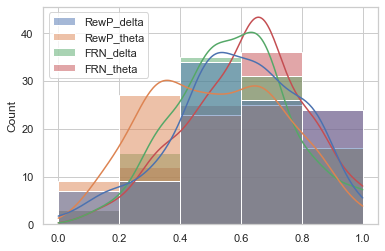

In [162]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [228]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,svc,RewP_Anxiety_band_0_svc,0.741379,0.653704,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1, 'svc...",0.013986,0.74,0.822222,0.566667,0.634343,0.709630,0.722222,0.653704
0,svc,RewP_Anxiety_band_1_svc,0.827586,0.620370,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.01, 'sv...",0.035964,0.55,0.433333,0.855556,0.590354,0.612963,0.800000,0.620370


In [229]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_precision,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy
0,svc,FRN_Anxiety_band_0_svc,0.827586,0.670370,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.1, 'svc...",0.009990,0.52,0.700000,0.600000,0.660943,0.606667,0.685185,0.670370
0,svc,FRN_Anxiety_band_1_svc,0.775862,0.642593,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 1, 'svc__...",0.056943,0.81,0.722222,0.655556,0.650000,0.729259,0.729630,0.642593


In [242]:
index = 1

In [243]:
anx_rewp_model = results_anx_rewp_df.iloc[index].best_model
anx_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.01,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f42f934a490>),
                ('svc', SVC(C=1, kernel='linear'))])

In [244]:
anx_frn_model = results_anx_frn_df.iloc[index].best_model
anx_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7f42f9128f70>),
                ('svc', SVC(C=10))])

In [245]:
X_rewp = rewp_anxiety_datasets[index]
X_frn = frn_anxiety_datasets[index]

- Balanced Accuracy

In [246]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [247]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.972
p value: 0.167


- Roc AUC

In [248]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [249]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.180
p value: 0.120


- precision

In [250]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [251]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.716
p value: 0.238


- recall

In [252]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [253]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.564
p value: 0.287


- F1

In [604]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [605]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.101
p value: 0.460


Visualize difference between FRN and RewP models

In [592]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [593]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

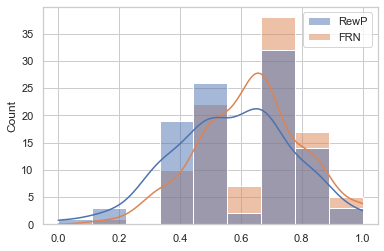

In [594]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [595]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [596]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

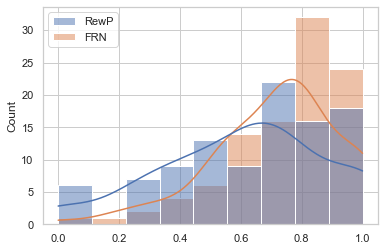

In [597]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)